In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from dawo import loss_function, DAWO, Anndata_to_Tensor


import json
import importlib
import sys
sc.set_figure_params(dpi=200, color_map = 'viridis_r')
sc.settings.verbosity = 1
sc.logging.print_header()


/home/paperspace/miniconda3/envs/GEARS-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 pynndescent==0.5.11


In [3]:
# load data
adata = sc.read_h5ad('DAWO/20250213.Tahoe.merged.pseudobulk.public.h5ad')

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes = 5000)
adata = adata[:, adata.var.highly_variable]

In [5]:
# get drug embeddings
with open('DAWO/drug_summaries.json', 'r') as f:
    drug_name = json.load(f)
drug_emb = np.load('DAWO/drug_summary_lowd.npy')
drug_structure = pd.read_csv('DAWO/chemberta_cls_embeddings.csv',   index_col='drug')
drug_semantic = pd.read_csv('DAWO/semantic_features_combined.csv',   index_col='drug')

drug_to_embedding = dict(zip(list(drug_name.keys()), drug_emb))
for i in drug_to_embedding.keys():
    drug_to_embedding[i] = np.concatenate((drug_to_embedding[i], drug_structure.loc[i].values, drug_semantic.loc[i].values))

In [6]:
adata_X = adata[adata.obs['drug'] != 'DMSO_TF']
drug_con = adata_X.obs['drugname_drugconc'].tolist()
drug_con = [ float(i.split("'")[2].replace(',', ''))  for i in drug_con]
adata_X.obs['dosage'] = drug_con

adata_X.obs['drug'] = adata_X.obs['drug'].astype(str)
adata_X.obs['drug'][ adata_X.obs['drug'] == 'Erdafitinib '] = 'Erdafitinib'
adata_X.obs['drug'][ adata_X.obs['drug'] == 'Selinexor '] = 'Selinexor'

Y_onehot = pd.get_dummies(adata_X.obs['drug']).astype(int)

/tmp/ipykernel_30489/4241962995.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_X.obs['dosage'] = drug_con
/tmp/ipykernel_30489/4241962995.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_X.obs['drug'][ adata_X.obs['drug'] == 'Erdafitinib '] = 'Erdafitinib'
/tmp/ipykernel_30489/4241962995.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_X.obs['drug'][ adata_X.obs['drug'] == 'Selinexor '] = 'Selinexor'


In [7]:
adata_control = adata[adata.obs['drug'] == 'DMSO_TF']
#adata_control =  sc.read_h5ad('DAWO/baseline_for_uce_uce_adata.h5ad')
#adata_control.obs['Cell_ID_Cellosaur'] = adata_control.obs['cell_line_id']


In [8]:
df_mutations = pd.read_parquet('DAWO/drivergene_cellline_matrix.parquet', engine='pyarrow')  # or engine='fastparquet'
df_mutations.index = df_mutations['cell_name']
df_mutations.drop(columns=['cell_name'], inplace=True)

In [9]:
## create control dataset matched with X
 
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*Observation names are not unique.*",
    category=UserWarning
)

cell_type_counts = adata_X.obs['Cell_Name_Vevo'].value_counts()
 
selected = []
import warnings

for cell_type, count in cell_type_counts.items():
    control_subset = adata_control[adata_control.obs['Cell_Name_Vevo'] == cell_type]
    
    indices = np.random.choice(control_subset.shape[0], size=count, replace=True)
    selected_cells = control_subset[indices]
    selected.append(selected_cells)
 
adata_Z = selected[0].concatenate(*selected[1:], index_unique=None)
sc.tl.pca(adata_Z, svd_solver="arpack")

/home/paperspace/miniconda3/envs/GEARS-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [10]:
Z_matrix = adata_Z.obsm['X_pca']
new_matrix = []

for i in range(len(adata_Z.obs['Cell_Name_Vevo'])):
    z = Z_matrix[i]
    mutation = df_mutations.loc[adata_Z.obs['Cell_Name_Vevo'].values[i]].values
    combined = np.concatenate((z, mutation))
    new_matrix.append(combined)

Z_matrix = np.array(new_matrix)


In [11]:
## create drug embeddings for each sample
drug_list_in_X = adata_X.obs['drug'].tolist()
Y_matrix = np.array([drug_to_embedding[drug] for drug in drug_list_in_X]) 

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

adata_X_tensor = Anndata_to_Tensor( adata_X,  device=device)
Z_tensor = torch.FloatTensor(Z_matrix)
Y_tensor = torch.FloatTensor(Y_matrix)
Y_onehot_tensor = torch.Tensor(Y_onehot.values)

Using device: cuda


In [13]:
# ood setting
ood_mask = (adata_X.obs['drug'] == 'Harringtonine') & (adata_X.obs['Cell_Name_Vevo'] == 'NCI-H460')
ood_indices = torch.where(torch.tensor(ood_mask.values))[0]
non_ood_indices = torch.where(~torch.tensor(ood_mask.values))[0]

X_ood = adata_X_tensor[ood_indices]
Y_ood = Y_tensor[ood_indices]
Z_ood = Z_tensor[ood_indices]
Y_onehot_ood = Y_onehot_tensor[ood_indices]

X_rest = adata_X_tensor[non_ood_indices]
Y_rest = Y_tensor[non_ood_indices]
Z_rest = Z_tensor[non_ood_indices]
Y_onehot_rest = Y_onehot_tensor[non_ood_indices]

full_dataset = TensorDataset(X_rest,  Y_rest,  Z_rest, Y_onehot_rest)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [14]:

 
num_epochs = 100
learning_rate = 1e-3


model = DAWO(input_dim_X = adata_X_tensor.shape[1], input_dim_Y = Y_tensor.shape[1], input_dim_Z = Z_tensor.shape[1],     num_classes= Y_onehot_tensor.shape[1]).to(device)
reconstruct_optimizer = optim.Adam(model.parameters(), lr=learning_rate)
classification_loss_fn = nn.CrossEntropyLoss()



In [15]:
def evaluate(model, dataloader, recon_loss_fn, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, Y_batch, Z_batch, Y_cate_batch in dataloader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Z_batch = Z_batch.to(device)
            Y_cate_batch = Y_cate_batch.to(device)

            x_hat, mu, logvar, y_cate_pred = model(X_batch, Y_batch, Z_batch)

            recon_loss = recon_loss_fn(x_hat, X_batch, mu, logvar)/1000
            class_loss = classification_loss_fn(y_cate_pred, Y_cate_batch)
            loss = class_loss + recon_loss
            total_loss += loss.item() * X_batch.size(0)

            preds = torch.argmax(y_cate_pred, dim=1)
            Y_true = torch.argmax(Y_cate_batch, dim=1)
            correct += (preds == Y_true).sum().item()
            total += Y_cate_batch.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [16]:
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for X_batch, Y_batch, Z_batch, Y_cate_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        Z_batch = Z_batch.to(device)
        Y_cate_batch = Y_cate_batch.to(device)

        reconstruct_optimizer.zero_grad()
        x_hat, mu, logvar, y_cate_pred = model(X_batch, Y_batch, Z_batch)

        recon_loss = loss_function(x_hat, X_batch, mu, logvar)/1000
        class_loss = classification_loss_fn(y_cate_pred, Y_cate_batch)
        loss = class_loss + recon_loss
        loss.backward()
        reconstruct_optimizer.step()

        total_train_loss += loss.item() * X_batch.size(0)

        preds = torch.argmax(y_cate_pred, dim=1)
        Y_true = torch.argmax(Y_cate_batch, dim=1)
        train_correct += (preds == Y_true).sum().item()
        train_total += Y_cate_batch.size(0)

    avg_train_loss = total_train_loss / train_total
    train_acc = train_correct / train_total

    val_loss, val_acc = evaluate(model, val_loader, loss_function, device)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2%}, "
            f"Val Acc: {val_acc:.2%}")
        

Epoch [1/100] - Train Loss: 10.6735, Train Acc: 3.42%, Val Acc: 3.89%
Epoch [5/100] - Train Loss: 6.6073, Train Acc: 9.77%, Val Acc: 12.55%
Epoch [10/100] - Train Loss: 4.8536, Train Acc: 44.67%, Val Acc: 59.42%
Epoch [15/100] - Train Loss: 4.2516, Train Acc: 59.43%, Val Acc: 71.41%
Epoch [20/100] - Train Loss: 3.9424, Train Acc: 67.39%, Val Acc: 78.99%
Epoch [25/100] - Train Loss: 3.7402, Train Acc: 73.55%, Val Acc: 83.94%
Epoch [30/100] - Train Loss: 3.5955, Train Acc: 78.06%, Val Acc: 86.21%
Epoch [35/100] - Train Loss: 3.4542, Train Acc: 81.89%, Val Acc: 89.37%
Epoch [40/100] - Train Loss: 3.3810, Train Acc: 83.98%, Val Acc: 90.39%
Epoch [45/100] - Train Loss: 3.3057, Train Acc: 85.64%, Val Acc: 89.96%
Epoch [50/100] - Train Loss: 3.2535, Train Acc: 87.15%, Val Acc: 91.34%
Epoch [55/100] - Train Loss: 3.2240, Train Acc: 87.92%, Val Acc: 91.30%
Epoch [60/100] - Train Loss: 3.2045, Train Acc: 88.82%, Val Acc: 91.45%
Epoch [65/100] - Train Loss: 3.1640, Train Acc: 89.37%, Val Acc: 92.

In [17]:

_, latent_emb,_ , _= model(adata_X_tensor.to(device), Y_tensor.to(device), Z_tensor.to(device))
adata_X.obsm['X_pca'] = latent_emb.detach().cpu().numpy()
n_pcs = adata_X.obsm['X_pca'].shape[1]
sc.pp.neighbors(adata_X, n_neighbors=10, n_pcs=n_pcs, use_rep='X_pca')
sc.tl.umap(adata_X)

/home/paperspace/miniconda3/envs/GEARS-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


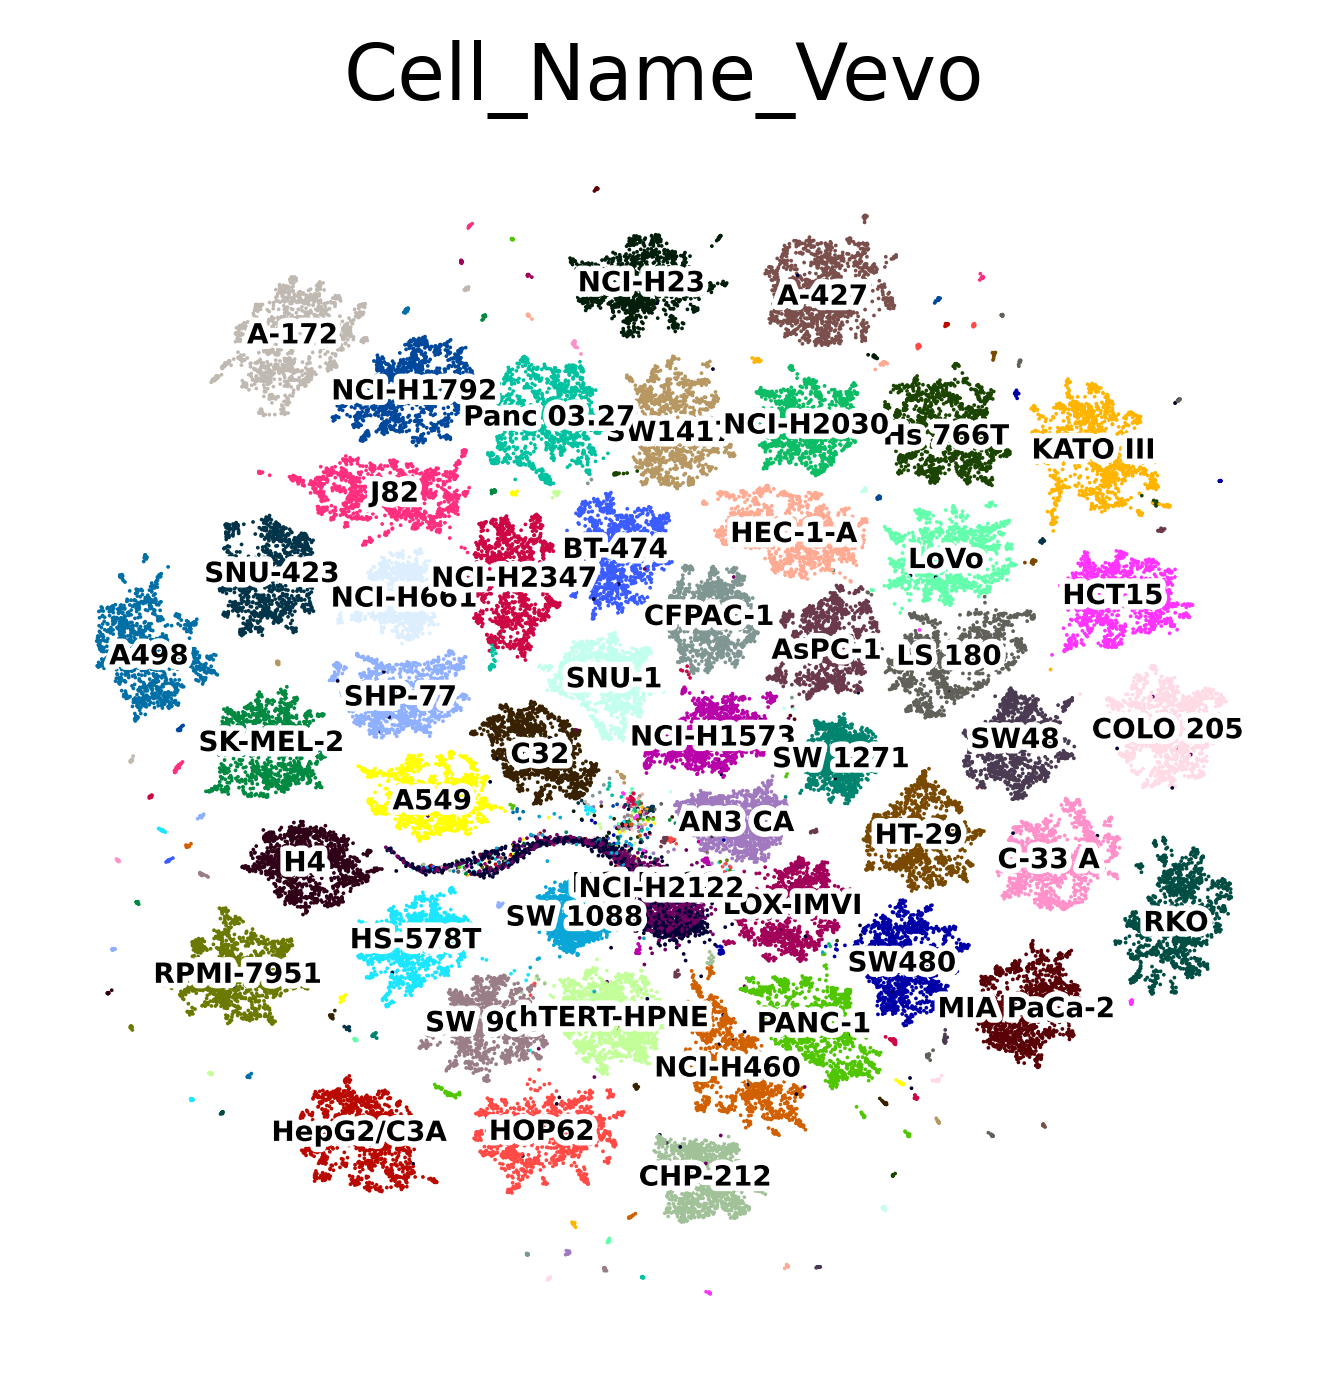

In [19]:
sc.pl.umap(adata_X, color=[ 'Cell_Name_Vevo' ], frameon=False, legend_fontsize=5, legend_fontoutline=2 , legend_loc='on data',)

